# Preprocessing search

In [1]:

import sys
import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd


from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score



from modules.preprocessing import preprocessing
import modules.preprocessing_tune as tune_pp


# Input data

In [3]:

data_url = "https://gitlab.com/vfonsecad/chemometrics_data/-/raw/main/data/nir_pharmaceutical_tablets/nir_shootout_2002_all.csv"
data_pd_raw = pd.read_csv(data_url, sep = ";", index_col = 0)
data_pd_raw.columns



Index(['sample_id', 'type', 'instrument', 'weight  ', 'hardness', 'assay   ',
       '1', '2', '3', '4',
       ...
       '641', '642', '643', '644', '645', '646', '647', '648', '649', '650'],
      dtype='object', length=656)

In [4]:
# model data

y_names = ['assay   '] # keeping it in list so that ycal is 2D for OSC preprocessing
cal_df = data_pd_raw[(data_pd_raw["instrument"] == "instrument_1") & (data_pd_raw["type"] == "calibration")]
test_df = data_pd_raw[(data_pd_raw["instrument"] == "instrument_1") & (data_pd_raw["type"] == "test")]

ycal = np.asarray(cal_df[y_names])
ytest = np.asarray(test_df[y_names])
xcal = np.asarray(cal_df.iloc[:,6:])
xtest = np.asarray(test_df.iloc[:,6:])

wv_range = np.arange(1,xcal.shape[1]+1) #no info about the wv range


# Preprocessing definition

In [5]:
# --- data for preprocessing

xcaldict = {"original": xcal}
xtestdict = {"original": xtest}



In [6]:
# osc

xcaldict_osc, xtestdict_osc = tune_pp.tune_osc(xcaldict, ycal, xtestdict, total_osc_range = np.arange(1,2), osc_lv_range = np.arange(1,15))

print("osc done")

osc done


In [7]:
# derivatives

xcaldict_derivatives, xtestdict_derivatives = tune_pp.tune_savgol_derivative(xcaldict, xtestdict, max_polynomial_order=5, min_derivative_order=2, 
                                                                             min_ww = 3, max_ww = 21,
                                                                             increase_step_ww=7)

print("deriv done")


deriv done


In [8]:
# msc


xcaldict_msc, xtestdict_msc = tune_pp.tune_msc(xcaldict, xtestdict, xmean=True, xmedian=True)

print("done msc")


done msc


In [9]:
# snv

xcaldict_snv, xtestdict_snv = tune_pp.tune_snv(xcaldict, xtestdict)


In [10]:
# deriv + osc osc(deriv)


xcaldict_deriv_osc, xtestdict_deriv_osc = tune_pp.tune_osc(xcaldict_derivatives, ycal, xtestdict_derivatives, total_osc_range = np.arange(1,2), osc_lv_range = np.arange(1,15))

print("deriv + osc done")

deriv + osc done


In [11]:
# msc + osc

xcaldict_msc_osc, xtestdict_msc_osc = tune_pp.tune_osc(xcaldict_msc, ycal, xtestdict_msc, total_osc_range = np.arange(1,2), osc_lv_range = np.arange(1,21))

print("msc + osc done")


msc + osc done


In [12]:
# snv + osc

xcaldict_snv_osc, xtestdict_snv_osc = tune_pp.tune_osc(xcaldict_snv, ycal, xtestdict_snv, total_osc_range = np.arange(1,2), osc_lv_range = np.arange(1,21))

print("msc + osc done")

msc + osc done


In [13]:
# merge all preprocessed data

final_xcal_dict = xcaldict.copy()

final_xcal_dict.update(xcaldict_msc)
final_xcal_dict.update(xcaldict_osc)
final_xcal_dict.update(xcaldict_derivatives)
final_xcal_dict.update(xcaldict_snv)
final_xcal_dict.update(xcaldict_deriv_osc)
final_xcal_dict.update(xcaldict_msc_osc)
final_xcal_dict.update(xcaldict_snv_osc)


final_xtest_dict = xtestdict.copy()

final_xtest_dict.update(xtestdict_msc)
final_xtest_dict.update(xtestdict_osc)
final_xtest_dict.update(xtestdict_derivatives)
final_xtest_dict.update(xtestdict_snv)
final_xtest_dict.update(xtestdict_deriv_osc)
final_xtest_dict.update(xtestdict_msc_osc)
final_xtest_dict.update(xtestdict_snv_osc)

print("done")

list(final_xcal_dict.keys()) == list(final_xtest_dict.keys())
# list(final_xtest_dict.keys())
# [ii for ii in final_xcal_dict.keys() if ii not in final_xtest_dict.keys()]

done


True

# Build all PLSR models

In [14]:
# loop parameters

total_lv = 30

performance_results = {}

# pls cv


total_lv = 30
n_splits_cv = 5

parameters = {'n_components': list(range(1,total_lv+1))}
pls_scoring = {'r2': 'r2', 'rmse': 'neg_root_mean_squared_error'}

ycal_pls = ycal[:,0]
ytest_pls = ytest[:,0]


# ! Start iterations
(This process might be time consuming)

In [18]:
# --- calibrate model with cal data 


start_time = datetime.datetime.now()

for key_pp in list(final_xcal_dict.keys()):  
    
    

    xcal_pls = final_xcal_dict[key_pp].copy()
    xtest_pls = final_xtest_dict[key_pp].copy()
    
    # cv   


    pls_cv = KFold(n_splits=n_splits_cv, shuffle=True)
    my_pls = PLSRegression(scale=False)
    my_pls_cv = GridSearchCV(my_pls, parameters, cv = pls_cv, scoring = pls_scoring, refit = False)
    my_pls_cv.fit(xcal_pls, ycal_pls)
    
    # model on test for all lv

    rmsep = np.zeros(total_lv)
    r2p = np.zeros(total_lv)

    
    my_pls_total = PLSRegression(n_components = total_lv,scale=False)
    my_pls_total.fit(xcal_pls, ycal_pls)
    x_mean = xcal_pls.mean(axis=0)
    y_mean = ycal_pls.mean(axis=0)

    T_scores = (xcal_pls-x_mean).dot(my_pls_total.x_rotations_)
    
    for chosen_lv in range(1, total_lv+1):
        
        my_pls_total_ls = LinearRegression()
        my_pls_total_ls.fit(T_scores[:,0:chosen_lv],ycal_pls) # output values need to be 1D always here

        
        B = my_pls_total.x_rotations_[:,0:chosen_lv].dot(my_pls_total_ls.coef_[0:chosen_lv])
        beta = y_mean - (x_mean.dot(B))

        ytest_pls_pred = xtest_pls.dot(B) + beta
        rmsep[chosen_lv-1] = np.sqrt(mean_squared_error(ytest_pls, ytest_pls_pred))
        r2p[chosen_lv-1] = r2_score(ytest_pls, ytest_pls_pred)



    performance_results[key_pp] = {"rmsecv" : -1*my_pls_cv.cv_results_["mean_test_rmse"],
                              "r2cv": my_pls_cv.cv_results_["mean_test_r2"],
                              "rmsep": rmsep,
                              "r2p": r2p}

    

finish_time = datetime.datetime.now()
print("done")


done


# Check results

Note that the r2 metric is indicative for a model also with low bias. See [sklearn.metrics.r2_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html)

In [37]:
pd.DataFrame.from_dict(performance_results, orient="index").shape
# performance_results.keys() # all preprocessing methods tested

(348, 4)

original + osc comp: 1 - osc_pls lv: 4
original + deriv ww:  19 - deriv order: 2 - poly order: 3
original + deriv ww:  19 - deriv order: 2 - poly order: 3 + osc comp: 1 - osc_pls lv: 1
original + deriv ww:  19 - deriv order: 2 - poly order: 3 + osc comp: 1 - osc_pls lv: 2
original + deriv ww:  19 - deriv order: 2 - poly order: 3 + osc comp: 1 - osc_pls lv: 3
original + deriv ww:  19 - deriv order: 2 - poly order: 3 + osc comp: 1 - osc_pls lv: 4
original + deriv ww:  19 - deriv order: 2 - poly order: 3 + osc comp: 1 - osc_pls lv: 5
original + snv + osc comp: 1 - osc_pls lv: 15
original + snv + osc comp: 1 - osc_pls lv: 18
original + snv + osc comp: 1 - osc_pls lv: 19
original + snv + osc comp: 1 - osc_pls lv: 20


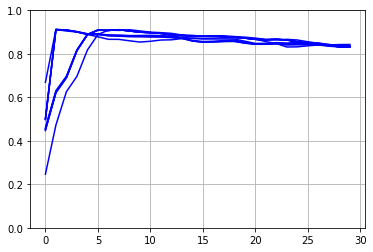

In [21]:
# performance curves


# plt.plot(performance_results["original"])
for key in performance_results.keys():
    if np.sum(performance_results[key]["r2p"]>0.911)>0:
        print(key)
        plt.plot(performance_results[key]["r2p"], c="blue")
plt.grid()
plt.ylim([0,1])
plt.show()

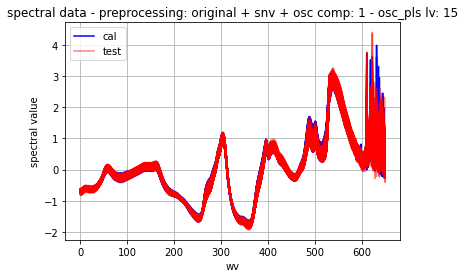

In [35]:
# indivial preproc spectra


key = "original + snv + osc comp: 1 - osc_pls lv: 15"

xcal_pls = final_xcal_dict[key].copy()
xtest_pls = final_xtest_dict[key].copy()



# visualize data

plt.plot(wv_range,xcal_pls[0], c = "blue", label = "cal")
plt.plot(wv_range,xcal_pls.T, c = "blue")
plt.plot(wv_range,xtest_pls[0], c = "red", alpha = 0.5, label = "test")
plt.plot(wv_range,xtest_pls.T, c = "red", alpha = 0.5)
plt.xlabel("wv")
plt.ylabel("spectral value")
plt.title("spectral data - preprocessing: {}".format(key))
plt.legend(loc = "upper left")
plt.grid()
plt.show()


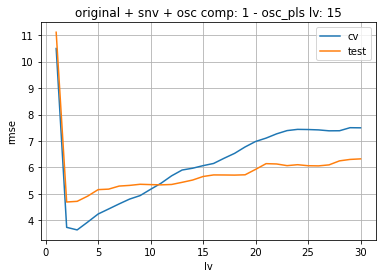

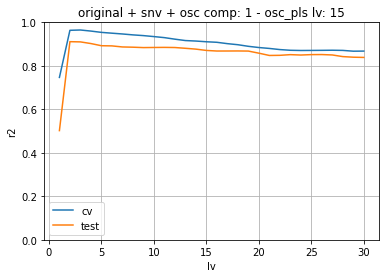

In [34]:
# individual results


plt.plot(np.arange(1, total_lv+1),performance_results[key]["rmsecv"], label = "cv")
plt.plot(np.arange(1, total_lv+1),performance_results[key]["rmsep"], label = "test")
plt.grid()
plt.ylabel("rmse")
plt.xlabel("lv")
plt.title(key)
plt.legend()
plt.show()

plt.plot(np.arange(1, total_lv+1),performance_results[key]["r2cv"], label = "cv")
plt.plot(np.arange(1, total_lv+1),performance_results[key]["r2p"], label = "test")
plt.ylim([0,1])
plt.ylabel("r2")
plt.xlabel("lv")
plt.grid()
plt.title(key)
plt.legend()
plt.show()

